In [1]:
!ls


Crimes_data.csv  crimes_ML.ipynb


In [1]:
import os

In [3]:
# os.chdir("./drive/MyDrive/Ford/")

In [65]:
!pip install plotly-geo==1.0.0
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.2 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.7/888.7 KB 1.5 MB/s eta 0:00:0000:0100:01
  Using cached Shapely-1.8.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 2.3 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 KB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
from sklearn import preprocessing
from sentence_transformers import SentenceTransformer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
le = preprocessing.LabelEncoder()

In [39]:
data =  pd.read_csv("Crimes_data.csv")

In [40]:
data.head(1)

,ID,Case Number,Date,Address,Crime Type Code,Primary Crime Type,Crime Description,Location Type,Arrest,Domestic Crime,Beat,District Code,Ward Number,Community Area Code
0,11798117,JC397040,17-08-2019 23:59,058XX W EDDY ST,820,THEFT,$500 AND UNDER,STREET,True,False,1633,16,36.0,15


In [41]:
data.columns

Index(['ID', 'Case Number', 'Date', 'Address', 'Crime Type Code',
       'Primary Crime Type', 'Crime Description', 'Location Type', 'Arrest',
       'Domestic Crime', 'Beat', 'District Code', 'Ward Number',
       'Community Area Code'],
      dtype='object')

> Drop NAN values from dataframe

In [42]:
data.dropna(inplace = True)

> ID and Case Number are irrelevant to the models. So removing those

In [43]:
drop_columns = ['ID', 'Case Number']
data.drop(columns = drop_columns, inplace = True)

> Spliting datetime into hour, day, month and year

In [44]:

data['date2'] = pd.to_datetime(data['Date'])
data['Year'] = data['date2'].dt.year
data['Month'] = data['date2'].dt.month
data['Day'] = data['date2'].dt.day
data['Hour'] = data['date2'].dt.hour
data['Minute'] = data['date2'].dt.minute
data['Second'] = data['date2'].dt.second 
data = data.drop(['Date'], axis=1) 
data = data.drop(['date2'], axis=1) 


## Visualizations

Visualizations was done by POwerBI as it provides more interactive reports and insights



> Convert into categories



In [35]:
categorical_columns = ['Location Type',  'Arrest', 'Domestic Crime', 'Primary Crime Type',  'Address', 'Crime Type Code']


In [36]:
data.columns

Index(['Address', 'Crime Type Code', 'Primary Crime Type', 'Crime Description',
       'Location Type', 'Arrest', 'Domestic Crime', 'Beat', 'District Code',
       'Ward Number', 'Community Area Code', 'Year', 'Month', 'Day', 'Hour',
       'Minute', 'Second'],
      dtype='object')

In [37]:
data = data.apply(lambda x:le.fit_transform(x) if x.name in categorical_columns else x)

To benchmark between contextual embeddins vs categorical label vector to understand if the context of the crime correlates with area

In [14]:
data['Crime Description Category'] = le.fit_transform(data['Crime Description'])

In [15]:
crime_description = data['Crime Description']
data.drop(columns = ['Crime Description'], inplace=True)

In [16]:
# date_columns = ['Date_hoursin', 'Date_hourcos', 'Date_daysin','Date_daycos', 'Date_monthsin', 'Date_monthcos', 'Date_year']
date_columns = ['Year', 'Month', 'Day', 'Hour', 'Minute','Second']

In [17]:
factor_analysis_columns = [i for i in data.columns if i not in date_columns]

The **Kaiser-Meyer-Olkin (KMO)** Test evaluates whether data are appropriate for factor analysis. It assesses the suitability of the model overall and for each observable variable. Value of KMO less than 0.6 is considered inadequate.

In [18]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(data[factor_analysis_columns])

In [19]:
kmo_model

0.6614005746224669

> The eigenvalue quantifies how much of the observed variables' common variance a factor explains.
Any factor with an eigenvalue greater than one explains more variance than a single variable. 

In [20]:
fa = FactorAnalyzer()
fa.fit(data[factor_analysis_columns])
eigen_values, vectors = fa.get_eigenvalues()# Check Eigenvalues
eigen_values

array([2.95575553e+00, 1.50710222e+00, 1.42679120e+00, 1.11853105e+00,
       9.34230326e-01, 8.42559518e-01, 7.25542569e-01, 5.44358390e-01,
       4.96451482e-01, 4.48589580e-01, 8.81288844e-05])

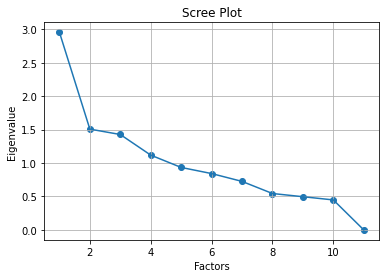

In [21]:
plt.scatter(range(1,data[factor_analysis_columns].shape[1]+1),eigen_values)
plt.plot(range(1,data[factor_analysis_columns].shape[1]+1),eigen_values)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [27]:
eigen_values


array([2.95575553e+00, 1.50710222e+00, 1.42679120e+00, 1.11853105e+00,
       9.34230326e-01, 8.42559518e-01, 7.25542569e-01, 5.44358390e-01,
       4.96451482e-01, 4.48589580e-01, 8.81288844e-05])

> Choosing factors which has eigenvalues greater than 1

In [22]:
significant_factors = {i: j for i,j in zip(data.columns[:10], eigen_values) if j > 1}

In [23]:
significant_factors

{'Address': 2.95575553242685,
 'Crime Type Code': 1.5071022239218457,
 'Primary Crime Type': 1.4267911978516812,
 'Location Type': 1.1185310514548812}

In [24]:
overall_factors = [list(significant_factors.keys()), date_columns]

In [25]:
overall_factors = list(itertools.chain(*overall_factors))

In [26]:
final_data = data[overall_factors]

In [27]:
final_data

,Address,Crime Type Code,Primary Crime Type,Location Type,Year,Month,Day,Hour,Minute,Second
0,18197,287,29,109,2019,8,17,23,59,0
1,2829,44,6,110,2019,8,17,23,59,0
2,8305,60,30,106,2019,8,17,23,57,0
3,22407,60,30,15,2019,8,17,23,55,0
4,21591,218,2,106,2019,8,17,23,45,0
...,...,...,...,...,...,...,...,...,...,...
161937,9891,80,27,95,2019,1,1,0,0,0
161938,5099,26,8,95,2019,1,1,0,0,0
161939,14639,26,8,17,2019,1,1,0,0,0
161940,14657,26,8,84,2019,1,1,0,0,0


In [34]:
label_column = "Primary Crime Type"
y = final_data[label_column]
X = final_data[[i for i in final_data.columns if i!=label_column]]

In [39]:

from sklearn.model_selection import cross_validate

def cross_validation(model, _X, _y, _cv=5):
    '''Function to perform 5 Folds Cross-Validation
    Parameters
    ----------
    model: Python Class, default=None
      This is the machine learning algorithm to be used for training.
    _X: array
       This is the matrix of features.
    _y: array
       This is the target variable.
    _cv: int, default=5
      Determines the number of folds for cross-validation.
    Returns
    -------
    The function returns a dictionary containing the metrics 'accuracy', 'precision',
    'recall', 'f1' for both training set and validation set.
    '''

    scoring = ['accuracy']
    results = cross_validate(estimator=model,
                           X=_X,
                           y=_y,
                           cv=_cv,
                           scoring=scoring,
                           return_train_score=True)

    return {
                "Training Accuracy scores": results['train_accuracy'],
                "Mean Training Accuracy": results['train_accuracy'].mean()*100
            }




In [44]:
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(40,), 
                         random_state=1,
                         max_iter=1000                         
                        )
knn_model = KNeighborsClassifier(n_neighbors=3)
models = [rf_model, nn_model, knn_model]


In [45]:
results =  {}
for model in models:
    results[f"{model}"] = cross_validation(model, X, y, _cv=5)


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [46]:
results

{'RandomForestClassifier(max_depth=50, min_samples_leaf=25, min_samples_split=30,\n                       n_estimators=70)': {'Training Accuracy scores': array([0.9601602 , 0.96035416, 0.96310412, 0.96868924, 0.96699279]),
  'Mean Training Accuracy': 96.3860101105708},
 'MLPClassifier(alpha=1e-05, hidden_layer_sizes=(40,), max_iter=1000,\n              random_state=1)': {'Training Accuracy scores': array([0.84160908, 0.915557  , 0.90817473, 0.87854492, 0.91599854]),
  'Mean Training Accuracy': 89.19768563889366},
 'KNeighborsClassifier(n_neighbors=3)': {'Training Accuracy scores': array([0.83216621, 0.83231469, 0.83277172, 0.83272524, 0.83277947]),
  'Mean Training Accuracy': 83.25514662548814}}

In [48]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [5,15,25],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [70, 100, 200, 300, 1000]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [49]:
grid_search.fit(X, y)


Fitting 3 folds for each of 360 candidates, totalling 1080 fits


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=70; total time=  14.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=  39.4s


/home/ubuntu/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=  14.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=  40.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=70; total time=  14.8s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=  41.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=  14.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time= 1.0min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  19.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=15, min_samples_split=12, n_estimators=200; total time=  38.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=1000; total time= 3.2min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=25, min_samples_split=10, n_estimators=200; total time=  36.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=25, min_samples_split=12, n_estimators=100; total time=  20.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=25, min_samples_split=12, n_estimators=200; total time=  40.7s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=  16.7s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time= 1.2min
[CV] END bootstrap=True, max_depth=80, max_features=2, min

[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  25.5s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000; total time= 4.0min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=  48.7s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=  25.0s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000; total time= 3.9min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000; total time= 3.6min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=  24.8s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_sa

[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=15, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=25, min_samples_split=8, n_estimators=1000; total time= 3.7min
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=70; total time=  14.3s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=  46.0s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time= 1.3min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=15, min_samples_split=8, n_estimators=70; total time=  15.4s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=15, min_samples_split=8, n_estimators=200; total time=  46.0s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samp

[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=15, min_samples_split=12, n_estimators=1000; total time= 3.3min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300; total time= 1.2min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=15, min_samples_split=12, n_estimators=70; total time=  15.7s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=15, min_samples_split=12, n_estimators=100; total time=  22.3s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=25, min_samples_split=8, n_estimators=100; total time=  20.7s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=25, min_samples_split=8, n_estimators=300; total time= 1.0min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=25, min_samples_split=12, n_estimators=70; total time=  15.4s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_

[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=100; total time=  20.3s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=25, min_samples_split=10, n_estimators=70; total time=  13.0s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=25, min_samples_split=10, n_estimators=200; total time=  38.0s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=25, min_samples_split=12, n_estimators=300; total time=  56.7s
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=  49.2s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=25, min_samples_split=10, n_estimators=100; total time=  19.3s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=25, min_samples_split=12, n_estimators=70; total time=  13.3s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_

[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=15, min_samples_split=8, n_estimators=1000; total time= 3.3min
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=1000; total time= 4.0min
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=15, min_samples_split=10, n_estimators=1000; total time= 3.4min
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000; total time= 3.9min
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=15, min_samples_split=10, n_estimators=300; total time= 1.0min
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=200; total time=  37.1s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=25, min_samples_split=10, n_estimators=300; total time=  55.8s
[CV] END bootstrap=True, max_depth=90, max_features=3, m

[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=  25.0s
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  24.1s
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=70; total time=  16.4s
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=  25.5s
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=15, min_samples_split=8, n_estimators=100; total time=  23.1s
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=15, min_samples_split=10, n_estimators=70; total time=  15.6s
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=15, min_samples_split=10, n_estimators=100; total time=  22.7s
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samp

[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=15, min_samples_split=8, n_estimators=1000; total time= 3.8min
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  21.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000; total time= 3.5min
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=1000; total time= 3.2min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=15, min_samples_split=8, n_estimators=100; total time=  21.9s
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=15, min_samples_split=8, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=25, min_samples_split=8, n_estimators=70; total time=  14.5s
[CV] END bootstrap=True, max_depth=80, max_features=3, min

[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=15, min_samples_split=10, n_estimators=1000; total time= 3.3min
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time= 1.2min
[CV] END bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=15, min_samples_split=8, n_estimators=1000; total time= 3.8min
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  21.3s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=70; total time=  14.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=  21.7s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=15, min_samples_split=8, n_estimators=70; total time=  12.7s
[CV] END bootstrap=True, max_depth=100, max_features=2, m

[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000; total time= 3.6min
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=25, min_samples_split=12, n_estimators=300; total time=  57.9s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=  48.4s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000; total time= 3.9min
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=  24.8s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  23.7s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=70; total time=  15.9s
[CV] END bootstrap=True, max_depth=100, max_features=3

[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=  14.6s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=25, min_samples_split=12, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time= 1.0min
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=  44.5s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=70; total time=  14.4s
[CV] END bootstrap=True, max_depth=110, max_features=2, m

[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=  21.2s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000; total time= 3.5min
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=15, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=25, min_samples_split=8, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=25, min_samples_split=12, n_estimators=70; total time=  15.6s
[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=25, min_samples_split=12, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=  42.2s
[CV] END bootstrap=True, max_depth=110, max_features

[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=  21.5s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=15, min_samples_split=8, n_estimators=70; total time=  13.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=15, min_samples_split=8, n_estimators=100; total time=  19.9s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=15, min_samples_split=10, n_estimators=70; total time=  12.4s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=15, min_samples_split=10, n_estimators=200; total time=  37.7s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=15, min_samples_split=12, n_estimators=200; total time=  40.1s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=300; total time=  54.9s
[CV] END bootstrap=True, max_depth=110, max_features=2

[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=100; total time=  18.7s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=25, min_samples_split=10, n_estimators=70; total time=  12.6s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=25, min_samples_split=10, n_estimators=200; total time=  36.8s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=25, min_samples_split=12, n_estimators=300; total time=  58.0s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=  47.3s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000; total time= 3.9min
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000; total time= 3.5min
[CV] END bootstrap=True, max_depth=110, max_feature

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 200}

[CV] END bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=15, min_samples_split=8, n_estimators=1000; total time= 3.8min
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  22.2s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=70; total time=  14.7s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=  42.6s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=15, min_samples_split=8, n_estimators=300; total time=  55.8s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=15, min_samples_split=12, n_estimators=200; total time=  39.4s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=25, min_samples_split=8, n_estimators=1000; total time= 3.1min
[CV] END bootstrap=True, max_depth=110, max_features=

[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000; total time= 4.0min
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=15, min_samples_split=10, n_estimators=70; total time=  15.7s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=15, min_samples_split=10, n_estimators=200; total time=  45.6s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=25, min_samples_split=8, n_estimators=70; total time=  14.1s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=25, min_samples_split=8, n_estimators=200; total time=  42.7s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=25, min_samples_split=10, n_estimators=200; total time=  43.2s
[CV] END bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=25, min_samples_split=12, n_estimators=200; total time=  44.0s
[CV] END bootstrap=True, max_depth=110, max_features

In [50]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 200}

In [58]:
param_dict = grid_search.best_params_

In [60]:
rf = RandomForestClassifier(bootstrap = param_dict["bootstrap"],max_depth = param_dict["max_depth"], max_features = param_dict["max_features"], min_samples_leaf = param_dict["min_samples_leaf"],min_samples_split = param_dict["min_samples_split"],n_estimators = param_dict["n_estimators"]    )

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2)

In [62]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, max_features=3, min_samples_leaf=5,
                       min_samples_split=12, n_estimators=200)

In [63]:
y_pred_test = rf.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.26      0.40        46
           1       0.96      1.00      0.98      2685
           2       0.97      1.00      0.99      6414
           3       1.00      0.99      1.00      1159
           4       1.00      0.27      0.42        26
           5       0.97      0.78      0.87       200
           6       1.00      0.99      0.99      3259
           7       0.95      0.99      0.97       844
           8       0.99      1.00      1.00      1999
           9       1.00      0.42      0.59        24
          10       1.00      0.58      0.74        72
          11       0.00      0.00      0.00         2
          12       0.99      0.85      0.92       185
          13       0.00      0.00      0.00        22
          14       0.00      0.00      0.00        19
          15       1.00      0.26      0.41        31
          16       1.00      1.00      1.00      1149
          17       0.97    

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
